In [1]:
# things to do/doubts/discussions
# how to save subclassing api
# do regularization
# hyperparameter tuning
# how to save the best model among all the epochs
# should we do augmentation of validation data ?
# should we shuffle repeat, prefetch etc ?
# All values are already between -1 to +1. should we do scaling ?
# if we are adding scaling of data, how to ensure that when it is being tested by brauer our code would give out rescaled data
# test cases are not sucessful

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
# import tensorflow_datasets as tfds

from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras import layers
# from sklearn import preprocessing
# Make numpy values easier to read.
# np.set_printoptions(precision=3, suppress=True)

# physical_devices = tf.config.list_physical_devices("gpu")
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.backend.set_floatx('float64')
tf.compat.v1.enable_eager_execution()

# np.random.seed(101)
# tf.random.set_seed(101)

import warnings
warnings.filterwarnings('ignore')

# GPUs Available:  1


In [3]:
# loading the data of data

leakage_train_100 = pd.read_csv("leakage_dataset_train_100.csv")
leakage_train_1000 = pd.read_csv("leakage_dataset_train_1000.csv")
leakage_val_1000 = pd.read_csv("leakage_dataset_validation_1000.csv")

In [4]:
def load_data(train_data):

    train_ds = train_data
    val_ds = leakage_val_1000

    train_ds = train_ds.sample(frac=1)
    val_ds = val_ds.sample(frac=1)

    X_train = train_ds.iloc[:,2:].to_numpy()
    Y_train = train_ds.iloc[:,:2]

    X_validation = val_ds.iloc[:,2:].to_numpy()
    Y_validation = val_ds.iloc[:,:2]

    Y_train = Y_train.to_numpy()
    Y_validation = Y_validation.to_numpy()
    return X_train, Y_train, X_validation, Y_validation

X_train, Y_train, X_validation, Y_validation = load_data(leakage_train_1000)


#test dataset
X_test = np.array([[0.25, 0.25, 0.25,0.25], 
                    [0.35, 0.15, 0.25,0.25], 
                    [0.25, 0.25, 0.15,0.35],
                    [0.15, 0.35, 0.25,0.25],
                    [0.25, 0.25, 0.35,0.15],
                    [0.4, 0.1, 0.25,0.25],
                    [0.05, 0.45, 0.25,0.25],
                    [0.45, 0.95, 0.25,0.25],
                    [0.25, 0.25, 0.45,0.05],
                    [0.25, 0.25, 0.05,0.45]])
                    
# scX = preprocessing.StandardScaler()
# stY = preprocessing.StandardScaler()

# def data_scaling(X_train, X_validation, Y_train, Y_validation, scX, stY):
#     X_train = scX.fit_transform(X_train)
#     X_validation = scX.transform(X_validation)

#     Y_train = stY.fit_transform(Y_train)
#     Y_validation = stY.transform(Y_validation)

#     return X_train, X_validation, Y_train, Y_validation

# X_train, X_validation, Y_train, Y_validation = data_scaling(X_train, X_validation, Y_train, Y_validation, scX, stY)

X_train = tf.convert_to_tensor(X_train)
X_validation = tf.convert_to_tensor(X_validation)
Y_train = tf.convert_to_tensor(Y_train)
Y_validation = tf.convert_to_tensor(Y_validation)
X_test = tf.convert_to_tensor(X_test)

# num_rows, num_cols = X_train.shape

In [5]:
batch_size = 64
epochs = 1000
# steps_per_epoch = sum(train_occurences) / batch_size
starter_learning_rate = 1e-1
end_learning_rate = 1e-8
decay_steps = epochs * 3
scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate= starter_learning_rate,
    decay_steps= decay_steps,
    end_learning_rate= end_learning_rate,
    power=1)
    
def learning_curves(history)   :
    sns.set_style('darkgrid', {'axes.facecolor': '.9'})
    sns.set_context('notebook')

    # your code
    ### Learning curves
    history_frame = pd.DataFrame(history.history)
    history_frame.plot(figsize=(8, 5))
    plt.show()

def prediction_accuracy(predictions, Y_validation): 
    predictions = predictions.transpose()
    Y_validation = tf.transpose(Y_validation)
    y1 = predictions[0]
    y2 = predictions[1]
    y1_validation = Y_validation[0]
    y2_validation = Y_validation[1]
    fig, axs = plt.subplots(2)
    # print(y1_validation.shape, y1.shape)
    # print(y2_validation.shape, y2.shape)
    # fig.suptitle('')
    axs[0].scatter(y1_validation, y1)
    axs[0].set_title('y1')
    axs[1].scatter(y2_validation, y2)
    axs[1].set_title('y2')
    for ax in axs.flat:
        ax.set(xlabel='true value', ylabel='predicted value')
    for ax in axs.flat:
        ax.label_outer()

    print("rmse of y1: ", mean_squared_error(y1_validation, y1, squared=False))
    print("rmse of y2: ", mean_squared_error(y2_validation, y2, squared=False))

# def dataloading(data):
#     data = data.repeat()
#     data = data.shuffle(buffer_size=1024, seed=0)
#     data = data.batch(batch_size=batch_size)
#     data = data.prefetch(buffer_size=1)
#     return data

In [6]:
# data Augmentation
# Requires cleaning up

def rotation_matrix(angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return R

def Augmentation_clock(x,y):

    x = x.copy()
    y = y.copy()
    # print(y)
    y_aug = np.transpose(np.matmul(rotation_matrix(-90), np.transpose(y)))
    # print(y_aug)

    temp = x.copy()
    x0 = temp[:,0]
    x1 = temp[:,1]
    x2 = temp[:,2]
    x3 = temp[:,3]

    x[:,0] = x3
    x[:,1] = x0
    x[:,2] = x1
    x[:,3] = x2
 
    return x,y_aug

def Augmentation_flip(x,y):
    x = x.copy()
    y = y.copy()
    x = np.flip(x, axis=1)
    y[:,1] = -1 * y[:,1]
    return x,y

def Augmentation_anticlock(x,y):

    x = x.copy()
    y = y.copy()
    y_aug = np.transpose(np.matmul(rotation_matrix(90), np.transpose(y)))

    temp = x.copy()
    x0 = temp[:,0]
    x1 = temp[:,1]
    x2 = temp[:,2]
    x3 = temp[:,3]

    x[:,0] = x1
    x[:,1] = x2
    x[:,2] = x3
    x[:,3] = x0
 
    return x,y_aug

def data_augmentation(x,y):
    x = x.numpy()
    y = y.numpy()
    x_aug1,y_aug1 = Augmentation_clock(x, y)
    x_aug2,y_aug2 = Augmentation_clock(x_aug1,y_aug1)
    x_aug3,y_aug3 = Augmentation_clock(x_aug2,y_aug2)
    x_aug4,y_aug4 = Augmentation_flip(x_aug3,y_aug3)
    x_aug5,y_aug5 = Augmentation_clock(x_aug4,y_aug4)
    x_aug6,y_aug6 = Augmentation_clock(x_aug5,y_aug5)
    x_aug7,y_aug7 = Augmentation_clock(x_aug6,y_aug6)
    X_train_Aug = np.concatenate((x, x_aug1, x_aug2, x_aug3, x_aug4, x_aug5, x_aug6, x_aug7))
    Y_train_Aug = np.concatenate((y, y_aug1, y_aug2, y_aug3, y_aug4, y_aug5, y_aug6, y_aug7))

    X_train_Aug = tf.convert_to_tensor(X_train_Aug)
    Y_train_Aug = tf.convert_to_tensor(Y_train_Aug)

    return X_train_Aug, Y_train_Aug

X_train_Aug, Y_train_Aug = data_augmentation(X_train, Y_train)
# X_validation_Aug, Y_validation_Aug = data_augmentation(X_validation, Y_validation)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 hidden_layer (Hidden_layer)  (None, 1, 4)             16        
                                                                 
 my_re_lu (MyReLU)           (None, 1, 4)              0         
                                                                 
 output_layer (Output_layer)  (None, 1, 2)             8         
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
16/16 - 1s - loss: 0.2862 - mean_squared_error: 0.2726 - val_loss: 0.2023 - val_mean_squared_error: 0.1860 - 1s/epoch - 71ms/step
Epoch 2/1000
16/16 - 0s - loss: 0.1734 - mean_squared_

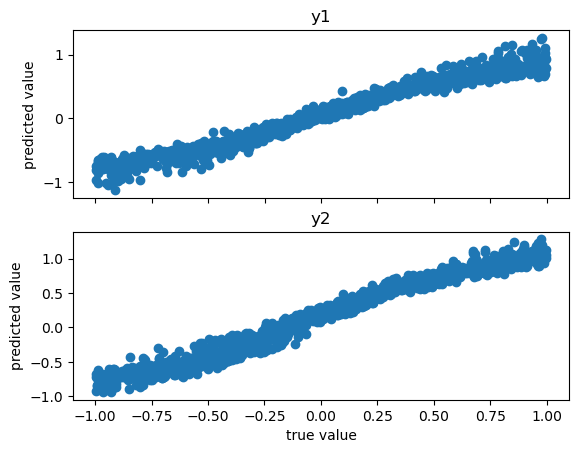

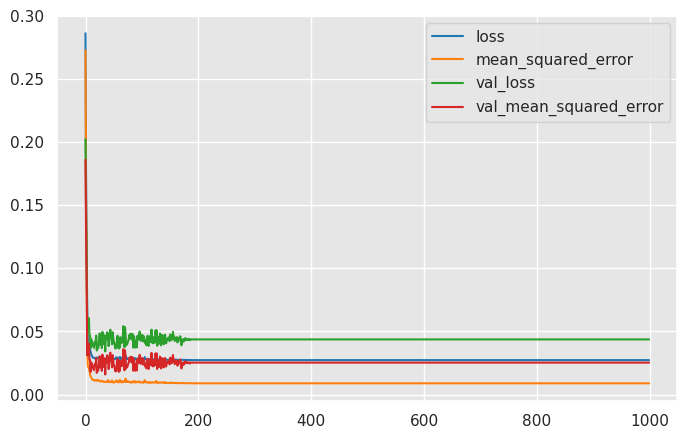

16/16 [==============================] - 0s 2ms/step - loss: 0.0437 - mean_squared_error: 0.0253


In [7]:
# A neural network with subclassing api on Augmented data

class Hidden_layer(layers.Layer):
    def __init__(self, units, kernel_regularizer):
        super(Hidden_layer, self).__init__()
        self.units = units
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1],self.units), initializer=tf.keras.initializers.HeUniform,
                                 trainable=True, regularizer=self.kernel_regularizer)

    def call(self, inputs):
        x = tf.matmul(inputs, self.W)
        return x

class Output_layer(layers.Layer):
    def __init__(self, units, kernel_regularizer):
        super(Output_layer, self).__init__()
        self.units = units
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1],self.units), initializer=tf.keras.initializers.HeUniform,
                                 trainable=True, regularizer=self.kernel_regularizer)

    def call(self, inputs):
        x = tf.matmul(inputs, self.W)
        return x

class MyReLU(layers.Layer):
    def __init__(self):
        super(MyReLU, self).__init__()

    def call(self, x):
        return tf.math.maximum(x, 0)

class MyModel(keras.Model):  # model.fit, model.evalute, model.predict
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = Hidden_layer(4, kernel_regularizer=tf.keras.regularizers.L1L2(0.001))
        # self.bn = tf.keras.layers.BatchNormalization()
        self.dense2_1 = Output_layer(2, kernel_regularizer=tf.keras.regularizers.L1L2(0.001))
        self.relu = MyReLU()

    def call(self, x):
        x = self.relu(self.dense1(x))
        return self.dense2_1(x)

    def build_graph(self):
        x = tf.keras.layers.Input(shape=(1,4))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

model = MyModel()
model.build_graph().summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler),
              loss='mean_squared_error',
              metrics = [tf.keras.metrics.MeanSquaredError()]
)

history = model.fit(X_train, Y_train, epochs=epochs, batch_size= batch_size, verbose=2, validation_data=(X_validation, Y_validation),
                    callbacks=[keras.callbacks.EarlyStopping(monitor='loss',patience=50)],
                    # shuffle=True
                    )

predictions = model.predict(X_validation)
prediction_accuracy(predictions, Y_validation)
learning_curves(history)

evaluate_train = model.evaluate(X_train_Aug, Y_train_Aug, batch_size=batch_size)
evaluate_validation = model.evaluate(X_validation,Y_validation, batch_size=batch_size)

In [8]:
y_pred = model.predict(X_test)
print(y_pred)

1/1 [==============================] - 0s 27ms/step
[[ 0.07487936  0.20864289]
 [-0.62257691  0.31034764]
 [-0.22868665 -0.04709265]
 [ 0.71232047 -0.0381715 ]
 [ 0.37844538  0.46437843]
 [-0.83035522  0.23130799]
 [ 1.13160368 -0.30836641]
 [ 0.5859817   2.18751899]
 [ 0.47480444  0.6979071 ]
 [-0.52933956 -0.17419318]]
